# Lens modeling of DESIJ1537+1443 with `lenstronomy`

Author(s): Md. Mehedi Hasan, Anowar J. Shajib

In [1]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

In [2]:
with h5py.File("DESIJ1537+1443_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data["image_data"]


with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"

C:\Users\HTCM\AppData\Local\Temp\ipykernel_4516\2739470995.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");


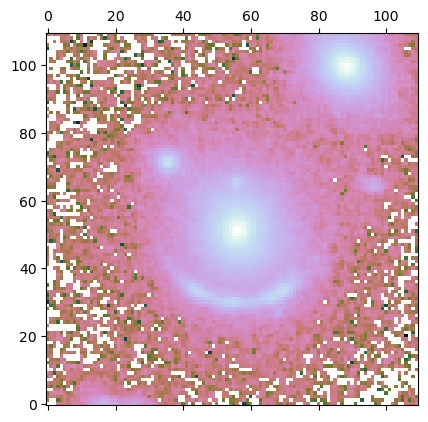

In [3]:
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");

## **A brief overview of lens modeling for DESIJ1537+1443:**
<p>We interpreted the arc spanning from roughly 4 o'clock to approximately 8:30 o'clock as the primary gravitational lensing structure, accompanied by a smaller blob positioned around 12 o'clock, which acted as its corresponding counter image. We employed masking to obscure elements in the image that were not related to gravitational lensing.</p>
<p>The modeling was started with the following lens, source and lens-light profiles:
    
    lens_model_list = ["EPL", "SHEAR"]
    source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
    lens_light_model_list = ["SERSIC_ELLIPSE"]

and the constraints: 
    
    joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]
    joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]
</p>
<p>The reduced chi-squared value converged at around 1.05 at first. We made the choice to avoid applying constraints and opted to fit the model with maximum flexibility.

Therefore, we eliminated the constraints and, in the new model, the Particle Swarm Optimization (PSO) yielded a value of approximately 0.98. However, there were some small yet persistent residuals at the 12 o'clock position. Consequently, we opted to keep the parameter <mark>**gamma**</mark> fixed for PSO during the fitting_sequence, allowing it to remain flexible for Markov Chain Monte Carlo (MCMC) optimization. With this adjustment, the MCMC chain exhibited a smooth convergence, and the updated model achieved a PSO value of around 0.94 and an MCMC value of approximately 0.90.</p>

## Likelihood mask:

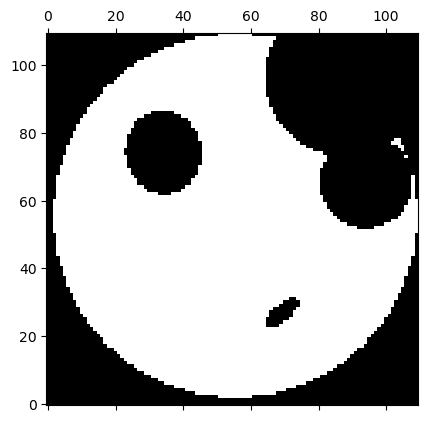

C:\Users\HTCM\AppData\Local\Temp\ipykernel_4516\1017133317.py:85: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
C:\Users\HTCM\AppData\Local\Temp\ipykernel_4516\1017133317.py:85: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


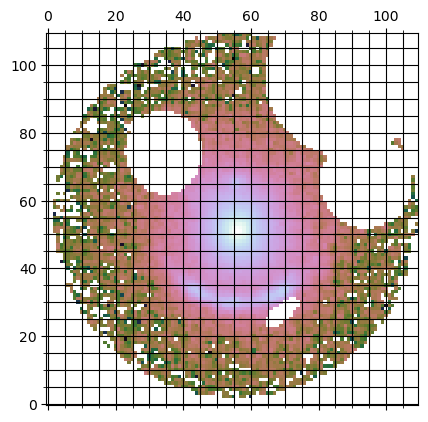

In [4]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)


r = 4.3  # In Arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra + 0,
    lens_center_dec + 0,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.6,
    lens_center_dec + 3.3,
    1.9,
    1.9,
    6,
)


mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.1,
    lens_center_dec + 0.8,
    1.1,
    1.1,
    6,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.7,
    lens_center_dec + 1.5,
    0.9,
    1,
    3,
)

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.1,
    lens_center_dec - 2.3,
    0.2,
    0.5,
    4,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# Masking Image Data
masked_image_data = np.multiply(image_data, mask)
plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

In [23]:
lens_model_list = ["EPL", "SHEAR"]

source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]

lens_light_model_list = ["SERSIC_ELLIPSE"]

In [32]:
# Lens Galaxy's Mass Model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append(
    {
        "theta_E": 1.5,  # 1.0
        "gamma": 2,  # 2.0
        "e1": -0.06,  # 0.0
        "e2": 0.03,  # 0.0
        "center_x": -0.06,
        "center_y": -0.34,
    }
)


kwargs_lens_init.append({"gamma1": 0.03, "gamma2": 0.01})


kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)

kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1})

kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -20,
        "center_y": -20,
    }
)

kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})  # 0.3

kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 20,
        "center_y": 20,
    }
)

kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# Lens Galaxy's Light Model

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 4.0})


kwargs_lens_light_init.append(
    {
        "R_sersic": 0.6,
        "n_sersic": 2,
        "e1": -0.06,
        "e2": 0.03,
        "center_x": -0.06,
        "center_y": -0.03,
        "amp": 16,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)


kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 3,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# Source Galaxy's Light Model

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({"n_sersic": 1.0})
fixed_source.append({"n_max": 6})

kwargs_source_init.append(
    {
        "R_sersic": 0.2,
        "n_sersic": 1,
        "e1": 0.2,
        "e2": 0.15,
        "center_x": -0.08,
        "center_y": -0.6,
        "amp": 16,
    }
)

kwargs_source_init.append({"beta": 0.04, "center_x": 0, "center_y": 0})


kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.08,
        "e2": 0.07,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_source_sigma.append({"beta": 0.02, "center_x": 0.2, "center_y": 0.2})


kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_lower_source.append({"beta": 0.01, "center_x": -5, "center_y": -5})

kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 3,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

kwargs_upper_source.append({"beta": 0.2, "center_x": 5, "center_y": 5})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# Combining Everything in `kwargs_params` Dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}


kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
}

In [33]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}


kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [34]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}


multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]


kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## Fitting the PSO sequence

In [16]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)


fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9463411601367023 reduced X^2 of best position
-3388.374523869463 log likelihood
7161 effective number of data points
[{'theta_E': 1.5525122003229412, 'gamma': 2, 'e1': -0.05769177339518761, 'e2': 0.02232760156766661, 'center_x': -0.05862385007979449, 'center_y': -0.297322453909998}, {'gamma1': 0.06580745179087988, 'gamma2': 0.0052267313635754615, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.14531262167411158, 'n_sersic': 1.0, 'e1': 0.12679816015777912, 'e2': 0.12235935918783751, 'center_x': -0.10936272153306645, 'center_y': -0.6812146408696116}, {'amp': 1, 'n_max': 6, 'beta': 0.040609770186533396, 'center_x': -0.10936272153306645, 'center_y': -0.6812146408696116}] source result
[{'amp': 1, 'R_sersic': 0.6845601940091743, 'n_sersic': 4.0, 'e1': -0.052955774850851296, 'e2': 0.0295681303257628, 'center_x': -0.06726844860994247, 'center_y': -0.34102830842407134}] lens light result
[] p

## Saving the resulting joblib file:

In [17]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1537+1443_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualization for the PSO fits:

-0.9400400954000452 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9400400954000439


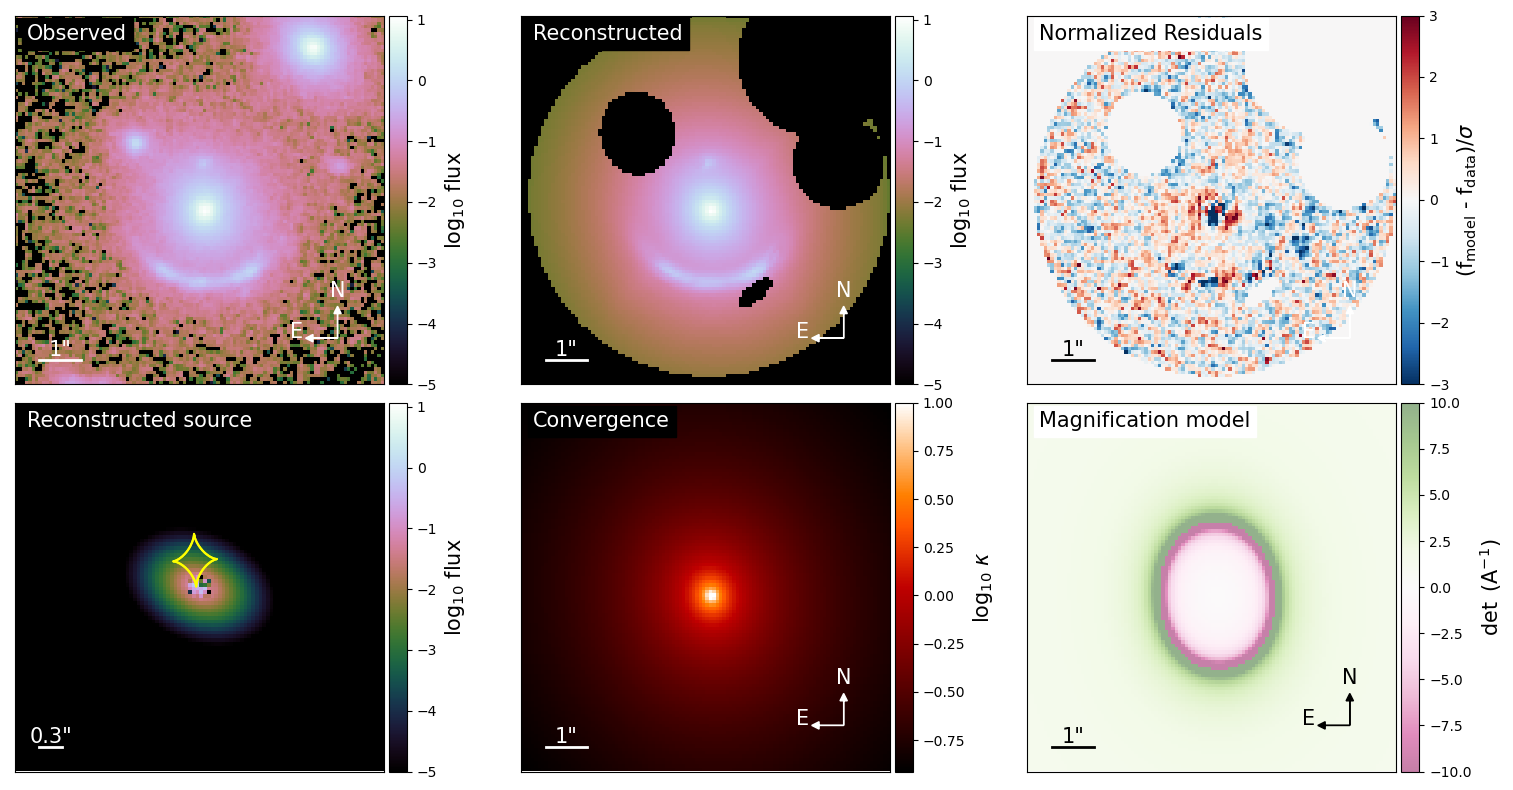

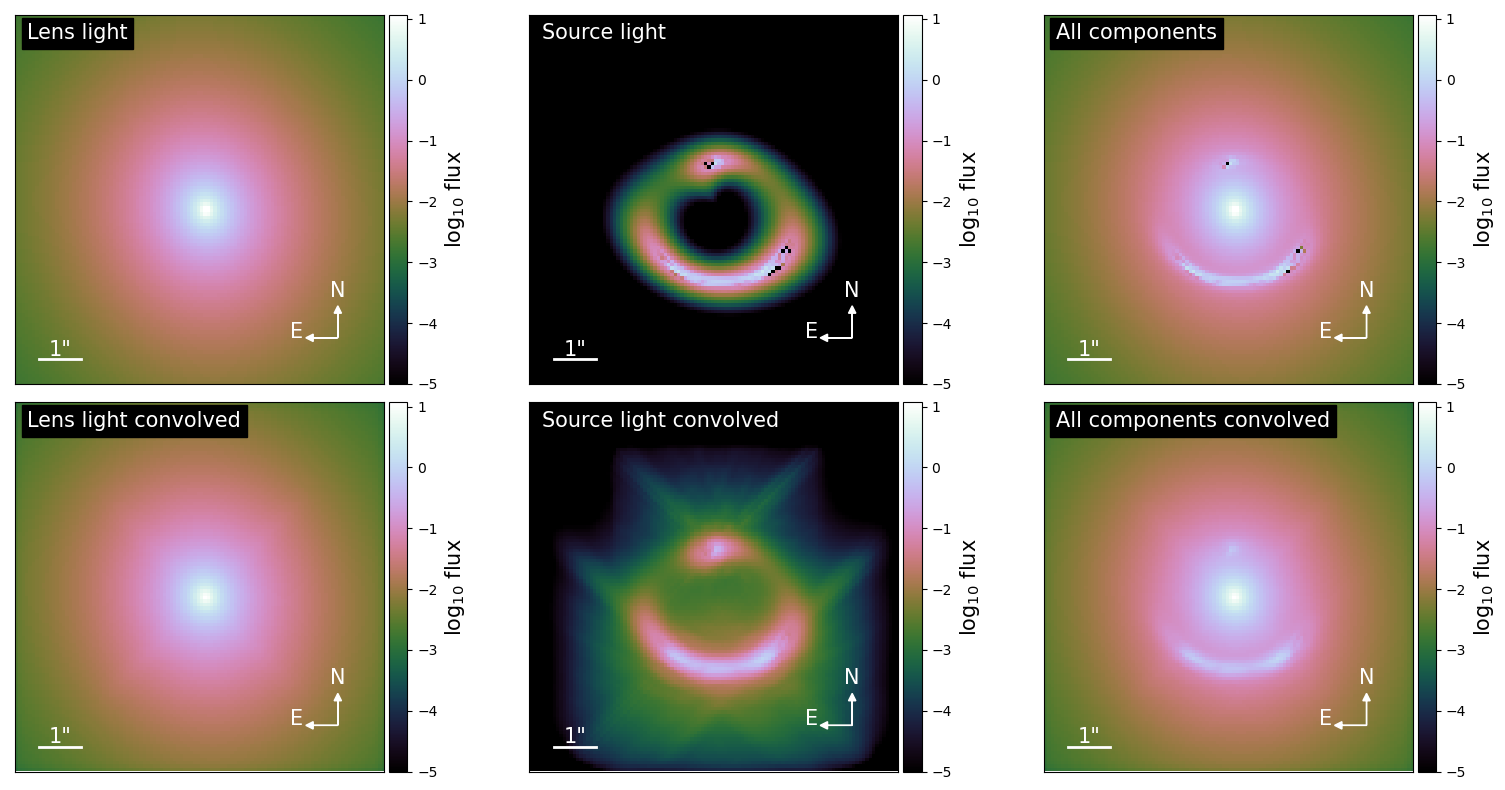

{'kwargs_lens': [{'theta_E': 1.5525122003229412, 'gamma': 2, 'e1': -0.05769177339518761, 'e2': 0.02232760156766661, 'center_x': -0.05862385007979449, 'center_y': -0.297322453909998}, {'gamma1': 0.06580745179087988, 'gamma2': 0.0052267313635754615, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 21.044437363183416, 'R_sersic': 0.14531262167411158, 'n_sersic': 1.0, 'e1': 0.12679816015777912, 'e2': 0.12235935918783751, 'center_x': -0.10936272153306645, 'center_y': -0.6812146408696116}, {'amp': array([ 213.13548941,  145.5420146 ,  -69.79679482,   31.23005031,
        205.21916564,   60.46036664,   46.51236997,  -69.55593862,
        -87.54407077,  -38.34946378,  197.47547067,   11.47920731,
         59.55701336,  -28.77631155,  -13.49747976,   70.32125687,
         82.37348254,   22.29759711,    8.19820822,   61.8170541 ,
          9.33527627, -119.02207662,    0.63777269, -162.59093349,
       -112.0646722 ,  -36.47749072,   51.13629506,    8.10632756]), 'n_max': 6, 'beta': 0.04060977

In [18]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])

model_plot.model_plot(ax=axes[0, 1])

model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")

model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.3
)

model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")

model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)

model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)

model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)

model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)

model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)

model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

plt.show()
print(kwargs_result)

## MCMC:

In [35]:
# Define the local path to save the backend file:


local_backend_path = "mcmc_backend.h5"

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 3000,
            "n_walkers": 200,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": local_backend_path,
            "start_from_backend": False,
        },
    ],
]

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)
chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|███████████████████████████████████████████████████████████████████████████| 3000/3000 [11:34:44<00:00, 13.89s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  0
Sampling iterations (in current run): 3000
41739.504717588425 time taken for MCMC sampling


## Trace plots of the resulting MCMC-run:

C:\Users\HTCM\AppData\Local\Temp\ipykernel_108\357921312.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 3000, N_walkers: 200, N_params: 19
theta_E_lens0 1.5009 ± 0.0109
gamma_lens0 2.1067 ± 0.0328
e1_lens0 -0.2368 ± 0.0143
e2_lens0 0.0925 ± 0.0083
center_x_lens0 -0.0637 ± 0.0054
center_y_lens0 0.1305 ± 0.0180
gamma1_lens1 0.0175 ± 0.0101
gamma2_lens1 0.0034 ± 0.0070
R_sersic_source_light0 0.2689 ± 0.0215
e1_source_light0 0.2656 ± 0.0271
e2_source_light0 0.0830 ± 0.0256
center_x_source_light0 -0.1742 ± 0.0117
center_y_source_light0 -0.6300 ± 0.0270
beta_source_light1 0.0899 ± 0.0044
R_sersic_lens_light0 0.6848 ± 0.0042
e1_lens_light0 -0.0561 ± 0.0021
e2_lens_light0 0.0270 ± 0.0020
center_x_lens_light0 -0.0676 ± 0.0005
center_y_lens_light0 -0.3416 ± 0.0007


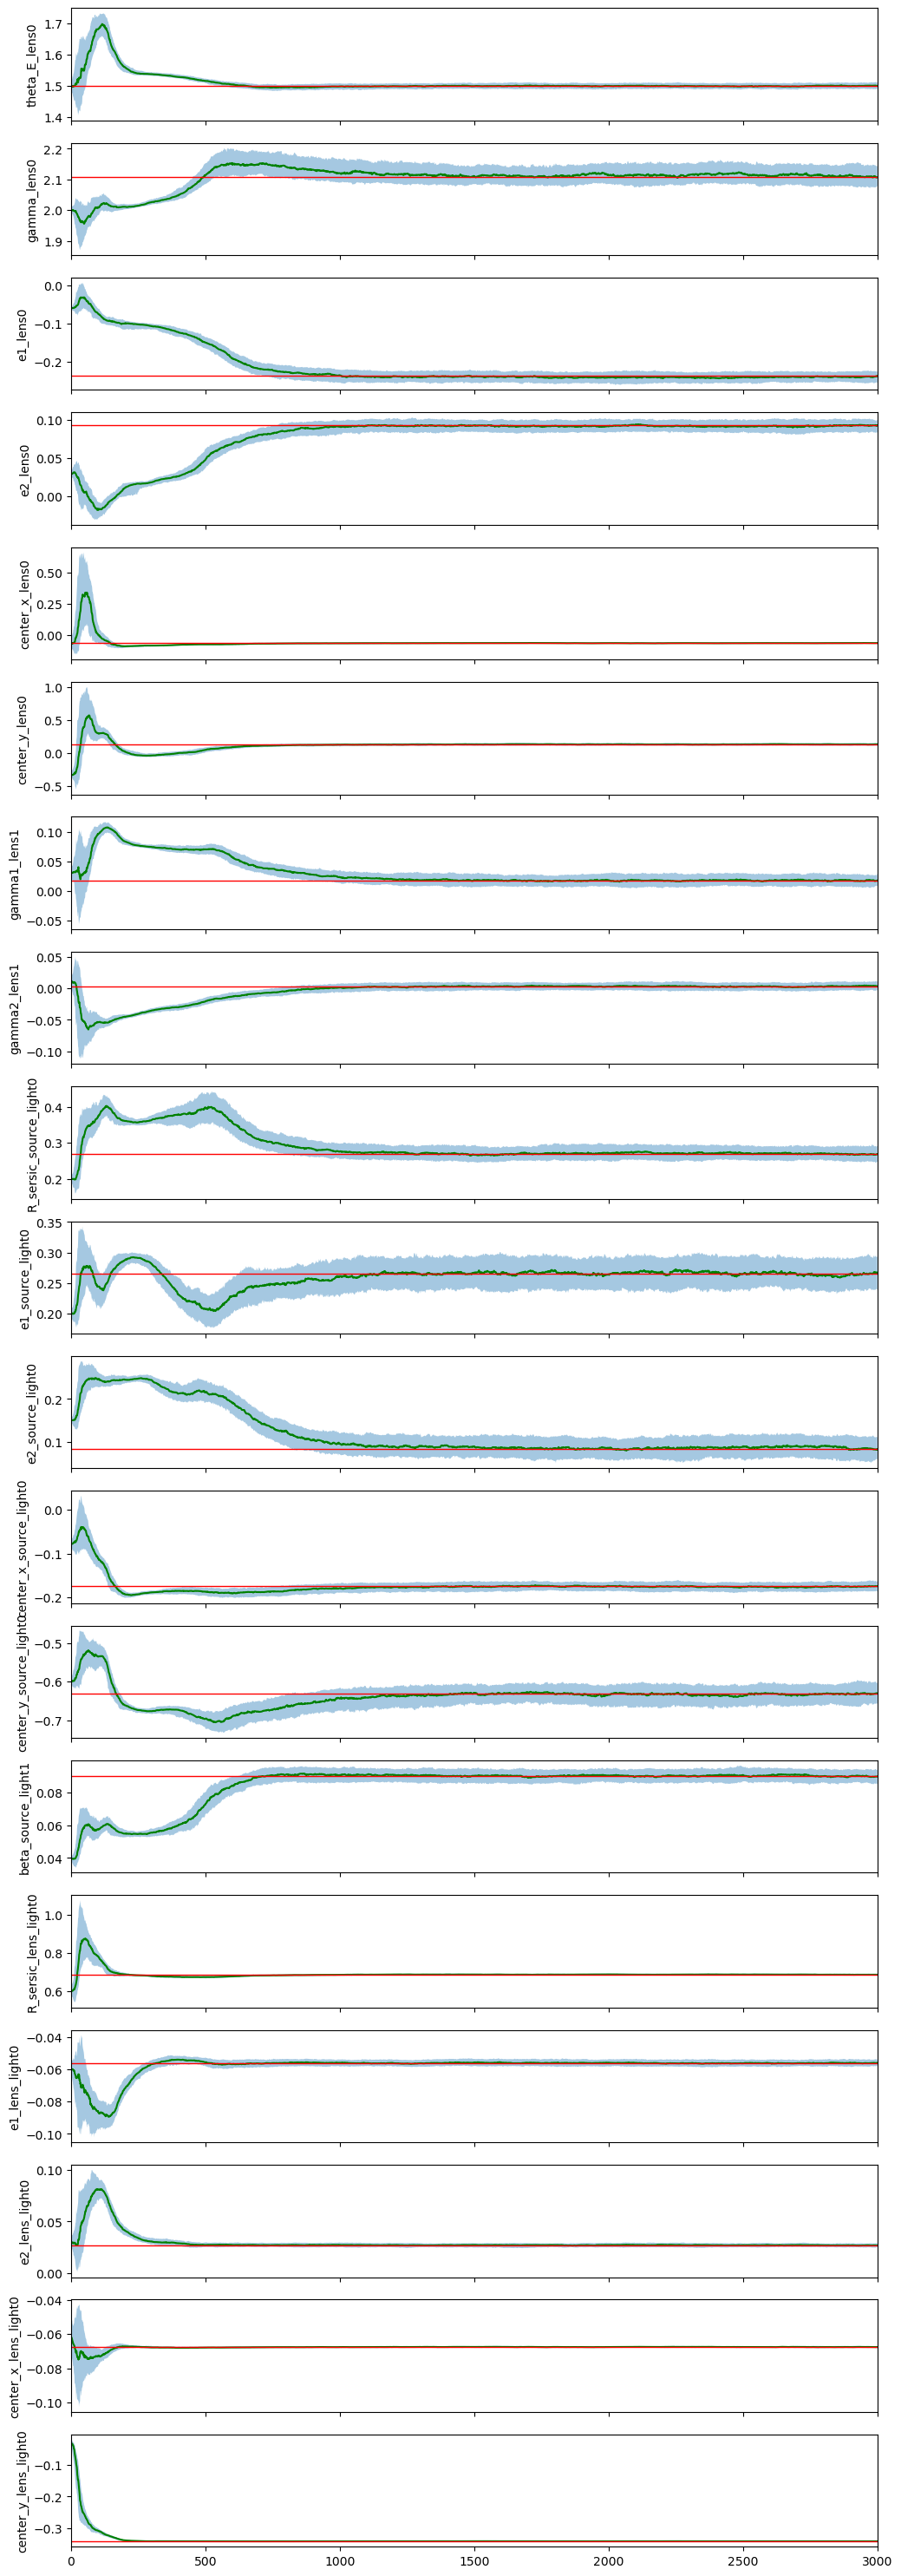

In [36]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        if samples_mcmc == []:
            samples_mcmc = chain_list_mcmc[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, chain_list_mcmc[k][1]))

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]
    n_walkers = 200
    n_step = 3000
    n_burn = 0

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )

        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))
    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

## The corresponding corner plots:

Number of non-linear parameters in the MCMC process: 19
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
Number of evaluations in the MCMC process: 600000
600000
Shape of samples_mcmc_cut: (15000, 19)


C:\Users\HTCM\AppData\Local\Temp\ipykernel_108\3583671573.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


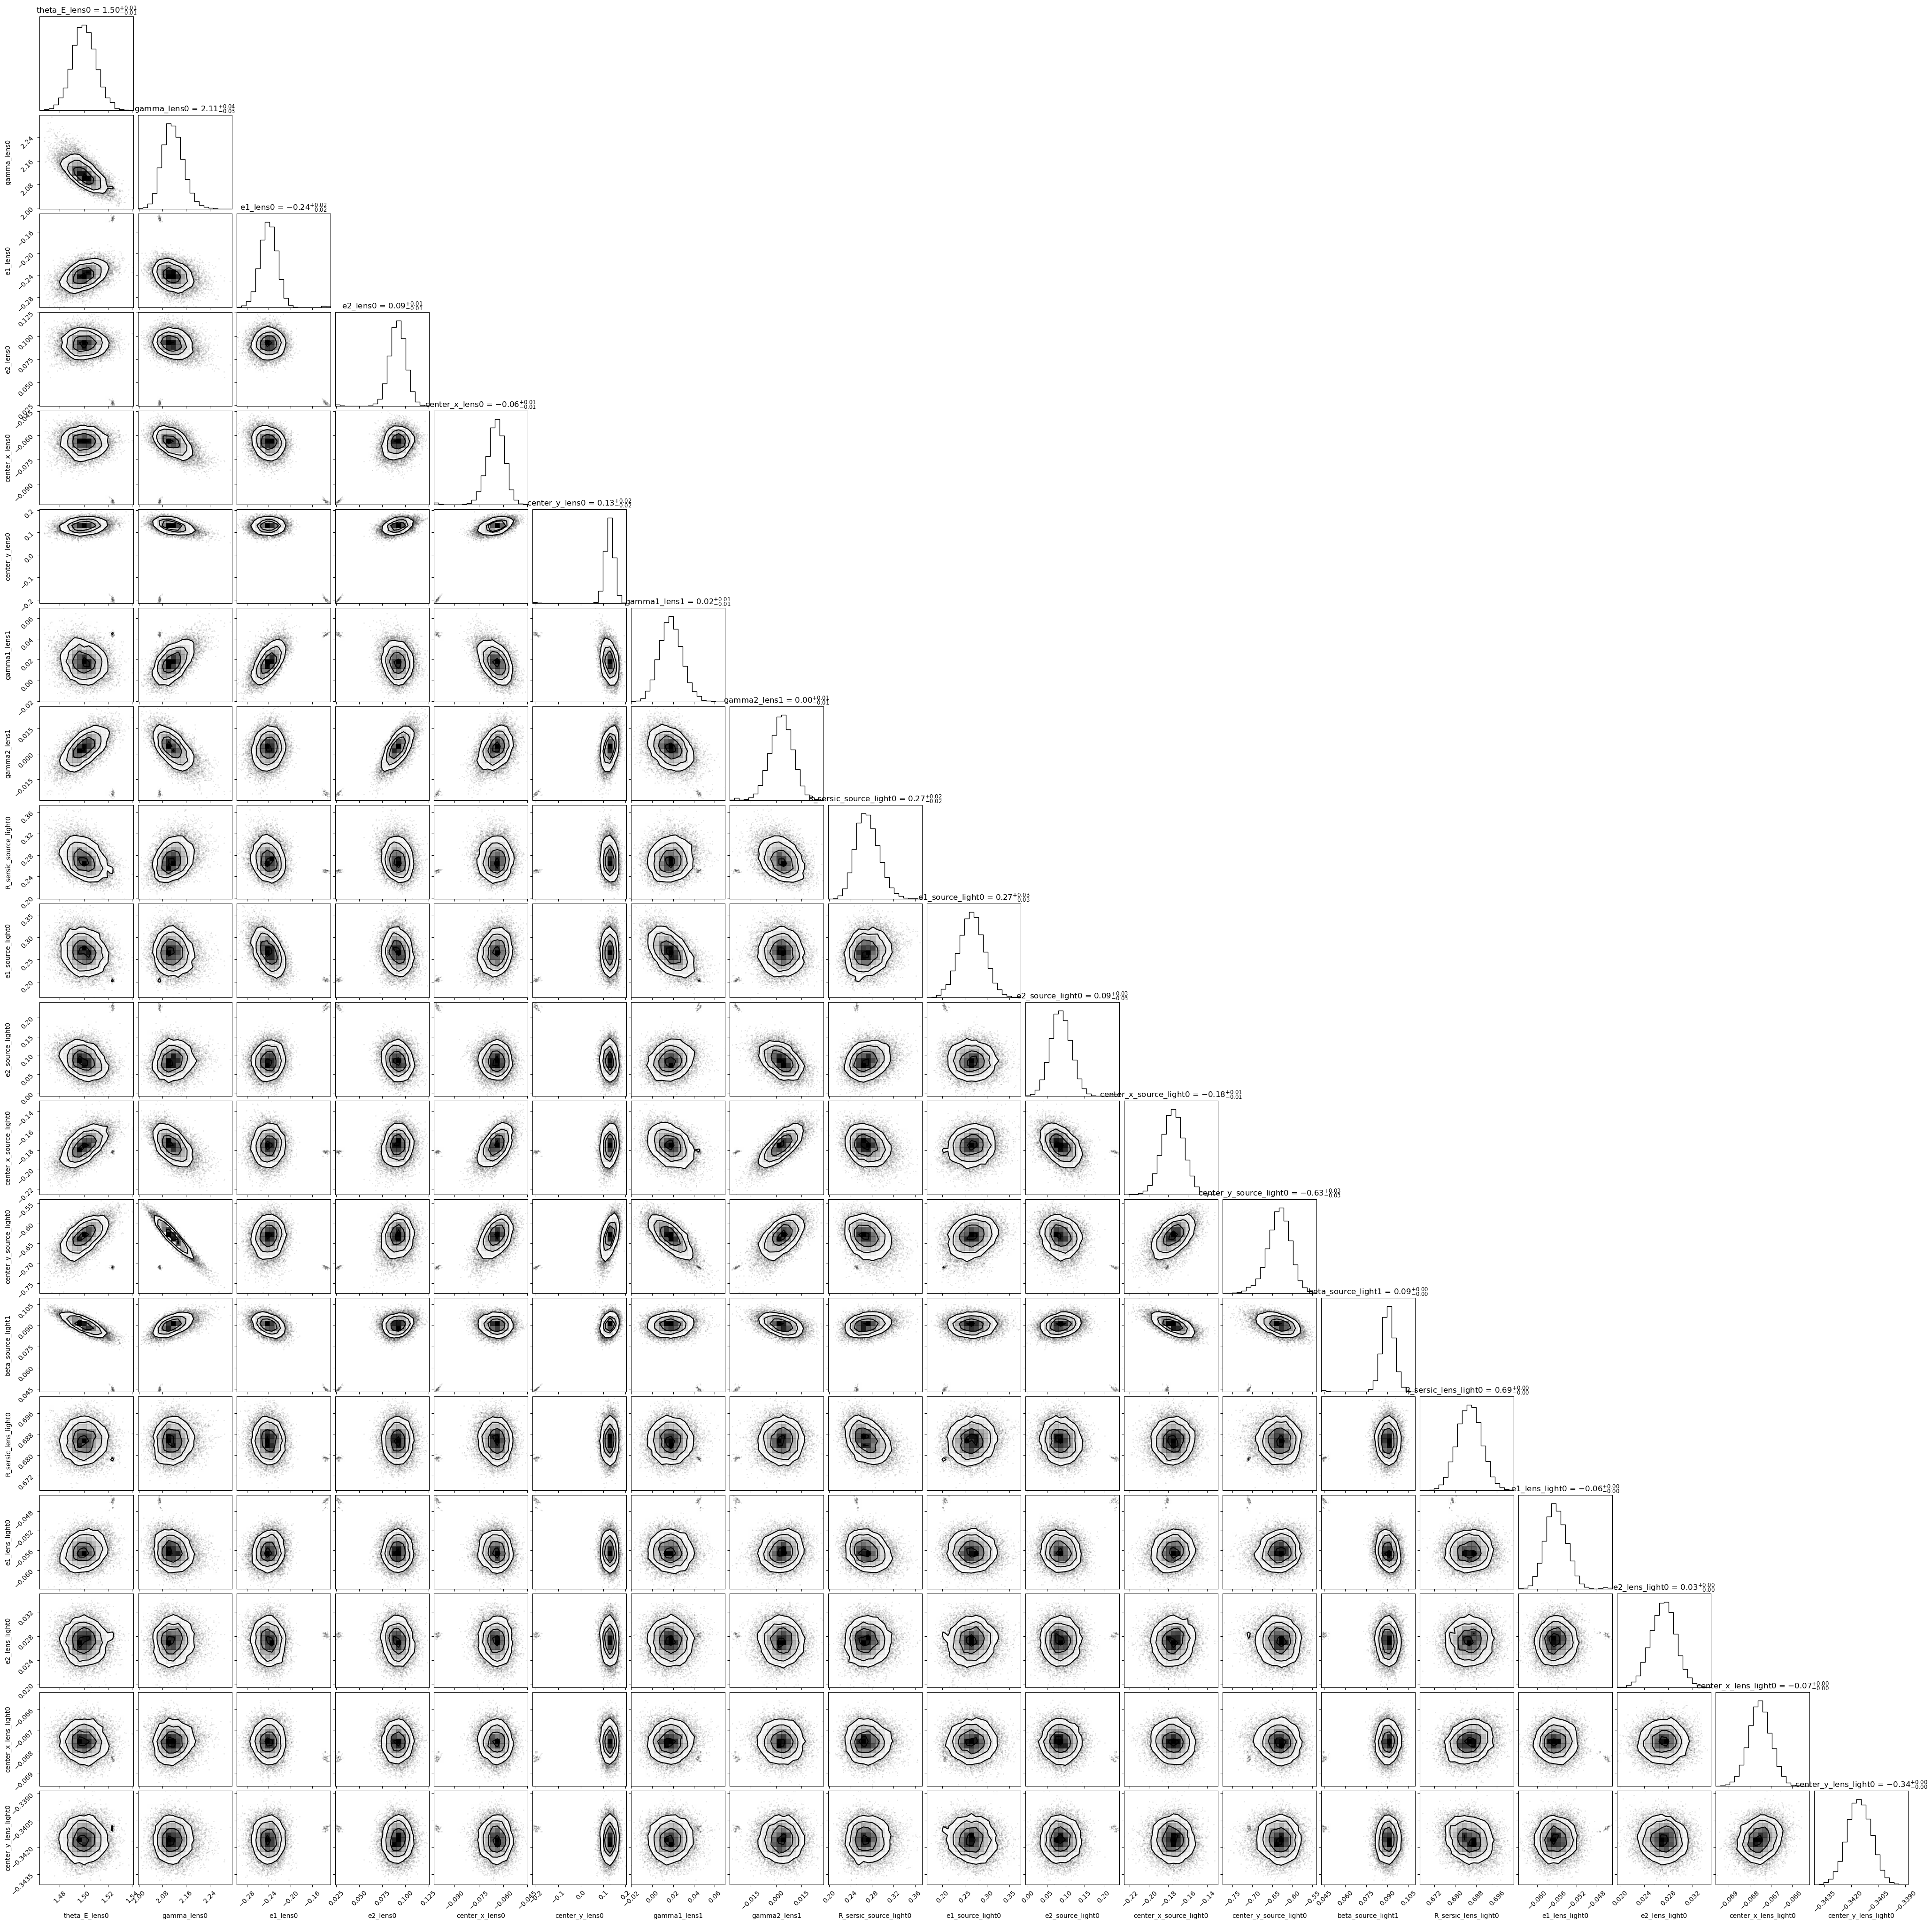

In [37]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 1500
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## Visualization of the MCMC fits:

-0.9033510665230072 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9033510665230063


C:\Users\HTCM\anaconda3\lib\site-packages\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
C:\Users\HTCM\anaconda3\lib\site-packages\lenstronomy\Plots\model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
C:\Users\HTCM\anaconda3\lib\site-packages\lenstronomy\Plots\model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
C:\Users\HTCM\AppData\Local\Temp\ipykernel_108\2343327444.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


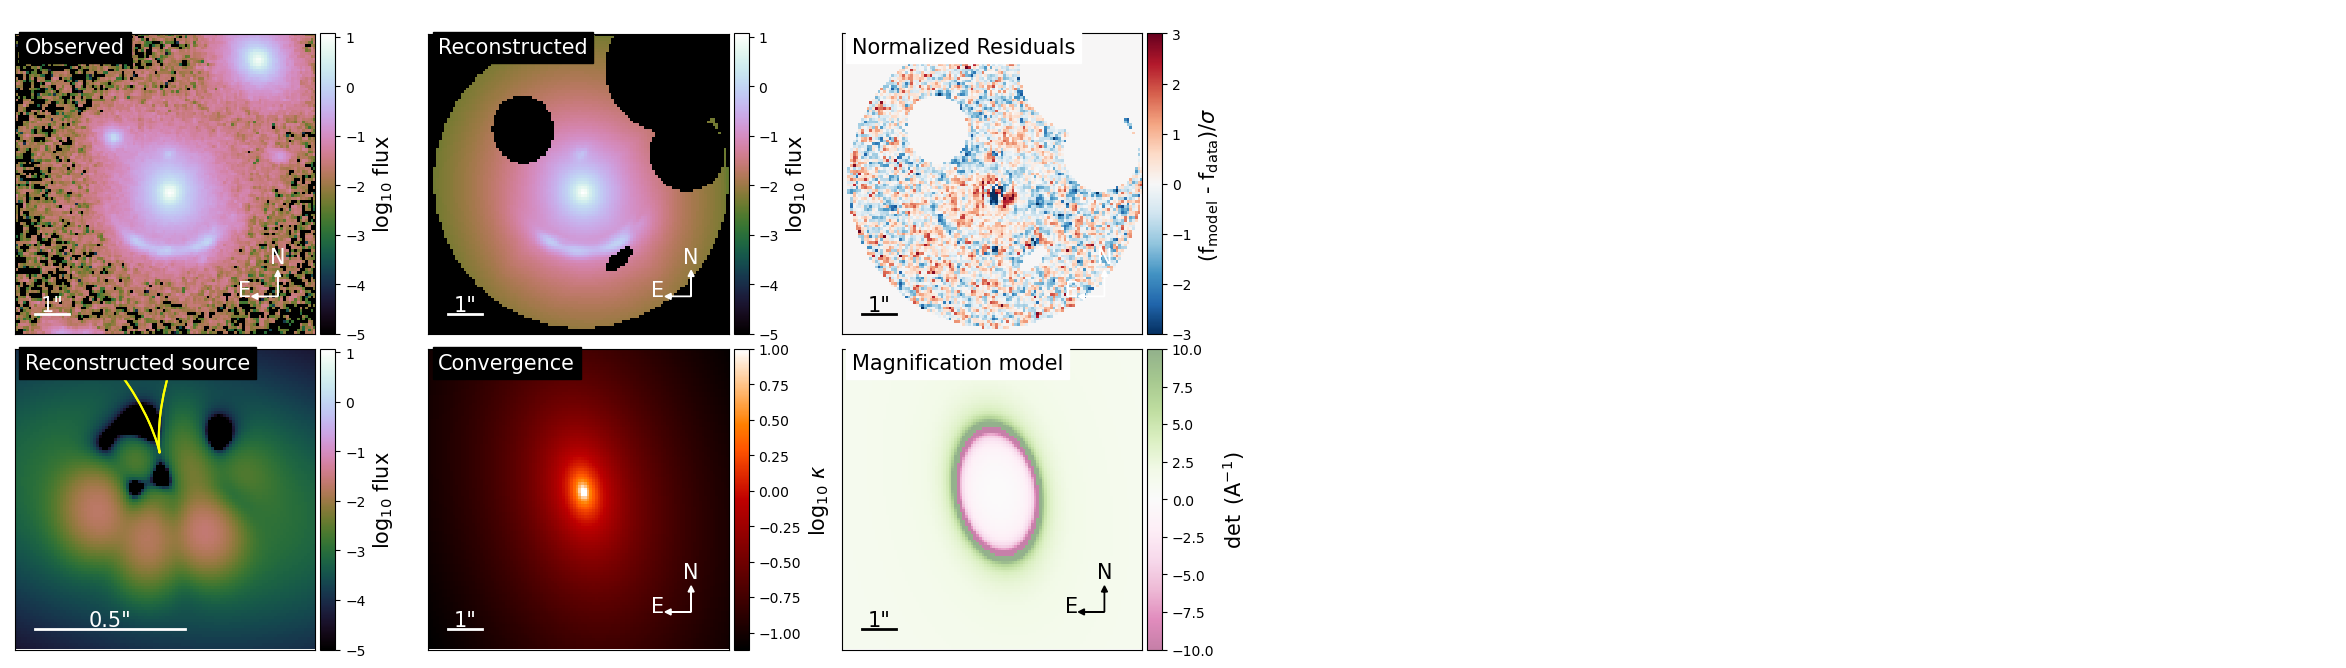

In [38]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

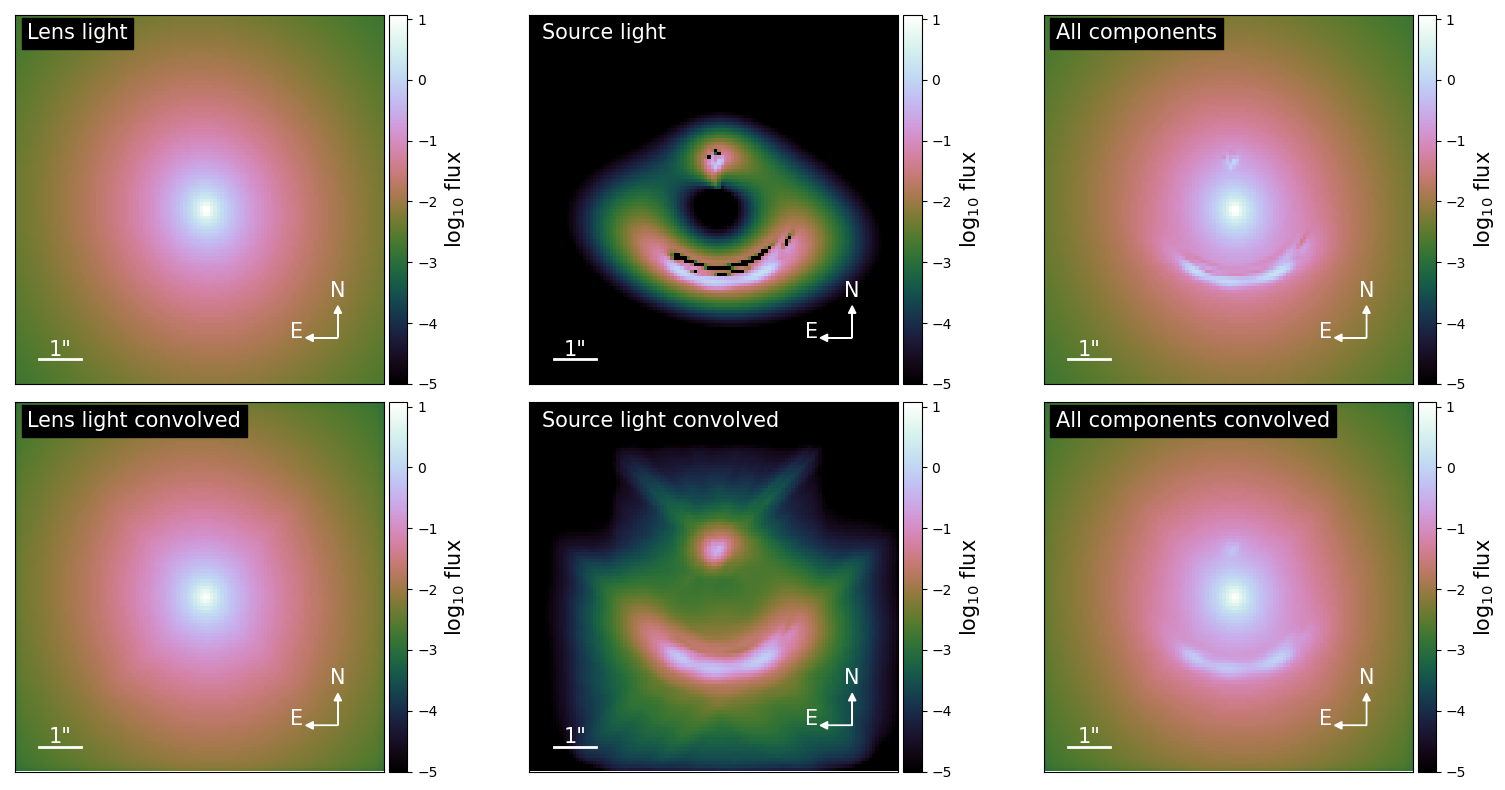

{'kwargs_lens': [{'theta_E': 1.4996326168071308, 'gamma': 2.111641358589654, 'e1': -0.23203667061848154, 'e2': 0.08773087179684402, 'center_x': -0.0659070423233353, 'center_y': 0.12330905048064905}, {'gamma1': 0.021003603672448683, 'gamma2': -0.0010568964001734646, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 13.034482807517326, 'R_sersic': 0.2742594556471692, 'n_sersic': 1.0, 'e1': 0.26363802855783774, 'e2': 0.1034796803207812, 'center_x': -0.18052405461375787, 'center_y': -0.6322737534044303}, {'amp': array([  71.14053852,  -38.10669001, -188.33187234,  162.12081198,
          9.57372091,  145.27265725,   62.61414184, -150.46110552,
        -27.87833542,  -61.40890604,   91.07633683,   24.46810043,
         71.20958875,   -1.22960757,   -2.15638461,  128.64520799,
        -49.32809262,  -63.77013045,  -25.28251373,    8.18616604,
         -5.06129936,   58.01761081,  -75.44835808,  -16.86470942,
         39.42626635,  -16.39870288,  -16.42293821,   -2.95684896]), 'n_max': 6, 'b

In [39]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result_mcmc)

## Saving the MCMC joblib file:

In [41]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = 2500  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result_mcmc, multi_band_list_out, kwargs_fixed_out]

output_path = "DESIJ1537+1443_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)